In [77]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.decomposition import PCA
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer, LabelBinarizer, Normalizer, OneHotEncoder
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
def group_feature(df, key, target, aggs):   
    """
    输出不同聚合字段-方法组合dataframe
    df 数据表
    key 用于分组的字段  x, y, v, d
    target 用于计算聚合的字段
    aggs  聚合的方法  ['max','min','mean','std','skew','sum']
    """
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag  # 例如 x_max 代表输出每个船（id）数据中里面的最大值
#     print(agg_dict)
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
#     print(t)
    return t

def extract_feature(df, train):
    # x的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','x',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # x的数量
    t = group_feature(df, 'ship','x',['count'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # y的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','y',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    
#     # speed_time 的最大值，最小值，平均值，标准差，峰度，加和
#     t = group_feature(df, 'ship','speed_time',['max','min','mean','std','skew','sum'])
#     train = pd.merge(train, t, on='ship', how='left')
    
    # xy 的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','xy',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # xy_loc_pca 的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','xy_loc_pca',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')    
    
#     # vd的最大值，最小值，平均值，标准差，峰度，加和
#     t = group_feature(df, 'ship','vd',['max','min','mean','std','skew','sum'])
#     train = pd.merge(train, t, on='ship', how='left')
    
    # 速度的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','v',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # 方向的最大值，最小值，平均值，标准差，峰度，加和
    t = group_feature(df, 'ship','d',['max','min','mean','std','skew','sum'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # x y 的最大值和最小值的交叉相减
    train['x_max_x_min'] = train['x_max'] - train['x_min']
    train['y_max_y_min'] = train['y_max'] - train['y_min']
    train['y_max_x_min'] = train['y_max'] - train['x_min']
    train['x_max_y_min'] = train['x_max'] - train['y_min']
    
    # slope 第一个值： y的最大值和最小值的差
    # slope 第二个值： x的最大值最小值的差，如果差值为0，则去极小值 0.001
    # slope代表x y 极差的比值，可以理解为斜度，坡度
    # np.where 是条件判断 True -> x;False -> y;
    train['slope'] = train['y_max_y_min'] / np.where(train['x_max_x_min']==0, 0.001, train['x_max_x_min'])
    # x y 的极差相乘，表示该船的最大活动面积
    train['area'] = train['x_max_x_min'] * train['y_max_y_min']
    
    # 每条船数据中出现小时值次数最多的值
    mode_hour = df.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
    train['mode_hour'] = train['ship'].map(mode_hour)
    
    # 小时的最大值，最小值
    t = group_feature(df, 'ship','hour',['max','min'])
    train = pd.merge(train, t, on='ship', how='left')
    
    # 一次任务涉及到的小时数值
    hour_nunique = df.groupby('ship')['hour'].nunique().to_dict()
    # 一次任务涉及的天数
    date_nunique = df.groupby('ship')['date'].nunique().to_dict()
    train['hour_nunique'] = train['ship'].map(hour_nunique)
    train['date_nunique'] = train['ship'].map(date_nunique)
    
    # 一次任务的时间差
    t = df.groupby('ship')['time'].agg({'diff_time':lambda x:np.max(x)-np.min(x)}).reset_index()
    # 时间差的天数，秒数
    t['diff_day'] = t['diff_time'].dt.days
    t['diff_second'] = t['diff_time'].dt.seconds
    train = pd.merge(train, t, on='ship', how='left')
    return train

def extract_dt(df):
    # 时间格式转换
#     df['time'] = pd.to_datetime(df['time'], format='%m%d %H:%M:%S')
    df['time'] = pd.to_datetime(df['time'])

    # df['month'] = df['time'].dt.month
    # df['day'] = df['time'].dt.day
    df['date'] = df['time'].dt.date  # 提取日期
    df['hour'] = df['time'].dt.hour  # 提取小时
    # df = df.drop_duplicates(['ship','month'])
    df['weekday'] = df['time'].dt.weekday  # 提取星期
    return df

def PAC():
    pass

In [3]:
# 读取数据，整理列信息
# train = pd.read_hdf('../input/train.h5')
train = pd.read_csv("/Users/nick/Documents/dataset/智慧海洋/train_v2.csv")
train = train.drop(["Unnamed: 0"], axis=1)
train = train.rename(columns={
    "速度": "v",
    "方向": "d",
    "渔船ID": "ship",
})
# train = df.drop_duplicates(['ship','type'])

In [4]:
# 读取数据，整理列信息
# test = pd.read_hdf('../input/test.h5')
test = pd.read_csv("/Users/nick/Documents/dataset/智慧海洋/test_v2.csv")

test = test.drop(["Unnamed: 0"], axis=1)
test = test.rename(columns={
    "速度": "v",
    "方向": "d",
    "渔船ID": "ship",
})

In [5]:
# 合并训练集和测试集
train["record"] = "train"
test["record"] = "test"
test["type"] = "未知"
df_all = pd.concat([train, test], axis=0)
df_all.head()

,d,record,ship,speed_time,time,type,v,x,y
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06


In [94]:
df_all.head(30)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy,date,hour,weekday
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44,"59,44",-0.002524,3183.035814,1900-11-06,23,1
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06,-0.063079,-0.152046,-0.255708,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06,-0.757161,1.141901,0.216781,59,44,"59,44",-0.002524,3183.041131,1900-11-06,23,1
5,158,train,6966,601.0,1900-11-06 22:58:16,围网,0.22,6.265902e+06,5.279254e+06,-0.039246,-0.139814,-0.260317,59,44,"59,44",-0.002524,3183.040285,1900-11-06,22,1
6,341,train,6966,600.0,1900-11-06 22:48:16,围网,0.22,6.265902e+06,5.279254e+06,-0.146946,-0.106280,-0.372765,59,44,"59,44",-0.002524,3183.034757,1900-11-06,22,1
7,254,train,6966,530.0,1900-11-06 22:39:26,围网,0.11,6.265902e+06,5.279254e+06,-0.064747,-0.147345,-0.251471,59,44,"59,44",-0.002524,3183.037385,1900-11-06,22,1
8,254,train,6966,74.0,1900-11-06 22:38:12,围网,0.11,6.265902e+06,5.279254e+06,-0.263923,-1.340200,3.420601,59,44,"59,44",-0.002524,3183.037385,1900-11-06,22,1
9,325,train,6966,1167.0,1900-11-06 22:18:45,围网,0.11,6.265902e+06,5.279254e+06,-0.083760,-0.115674,-0.244938,59,44,"59,44",-0.002524,3183.035240,1900-11-06,22,1


In [6]:
# 查看数据的相关统计指标
df_all.describe()

#  7.667581e+06

#  3.345433e+06

#           5.000250e+06    7.133785e+06

,d,ship,speed_time,v,x,y
count,3.482016e+06,3.482016e+06,3.473016e+06,3.482016e+06,3.482016e+06,3.482016e+06
mean,1.154757e+02,4.507147e+03,6.516602e+02,1.794424e+00,6.276965e+06,5.272255e+06
std,1.167185e+02,2.601711e+03,4.423489e+02,2.484245e+00,2.683253e+05,2.569539e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,5.000250e+06,3.345433e+06
25%,0.000000e+00,2.251000e+03,5.990000e+02,1.100000e-01,6.118252e+06,5.114766e+06
50%,8.100000e+01,4.516000e+03,6.000000e+02,3.200000e-01,6.246523e+06,5.232996e+06
75%,2.170000e+02,6.768000e+03,6.030000e+02,3.290000e+00,6.371401e+06,5.379706e+06
max,3.600000e+02,8.999000e+03,8.594500e+04,1.001600e+02,7.133785e+06,7.667581e+06


In [7]:
# x y 值统计特征
df_all_xy_count = df_all[["ship", "x", "y"]]

print("df_all_xy_count", df_all_xy_count.shape)
df_all_xy_count = df_all_xy_count.drop_duplicates(["ship", "x", "y"])
print("df_all_xy_count", df_all_xy_count.shape)

df_all_xy_count["x"] = (df_all_xy_count["x"]/10).astype(int)
df_all_xy_count["y"] = (df_all_xy_count["y"]/10).astype(int)

# df_all_xy_count["ship"] = df_all_xy_count.astype("object")
# df_all_xy_count["x"] = df_all_xy_count.astype("object")
# df_all_xy_count["y"] = df_all_xy_count.astype("object")

x_counts = df_all_xy_count.groupby("x")["x"].count()
x_count_dict = x_counts[x_counts >= 30].to_dict()

y_counts = df_all_xy_count.groupby("y")["y"].count()
y_count_dict = y_counts[y_counts >= 30].to_dict()

# x_count_dict
# y_count_dict

print("x_count_dict: {}".format(len(x_count_dict)))
print("y_count_dict: {}".format(len(y_count_dict)))

df_all_xy_count (3482016, 3)
df_all_xy_count (1521436, 3)
x_count_dict: 7867
y_count_dict: 10803


In [8]:
# 查看xy的交叉值
set(x_count_dict) & set(y_count_dict)

{522993}

In [9]:
# 查看ship的id是否是递增
df_all_xy_count.groupby("ship")["ship"].count()

ship
0        23
1       138
2         4
3       100
4       162
5        93
6       392
7       198
8       333
9         1
10       97
11       97
12      233
13       12
14       11
15      341
16      258
17      186
18        4
19      209
20      307
21      187
22      117
23       58
24      365
25      378
26      242
27        4
28      278
29      291
       ... 
8970    334
8971    179
8972    275
8973    321
8974     88
8975    386
8976    349
8977     70
8978    328
8979    325
8980    263
8981    303
8982     18
8983    136
8984    387
8985    402
8986     11
8987    107
8988    349
8989    161
8990    196
8991    111
8992      5
8993      4
8994     13
8995     93
8996    186
8997      2
8998    167
8999      4
Name: ship, Length: 9000, dtype: int64

In [10]:
# 制作坐标列表
x_count_list = []
y_count_list = []
ship_list = []
for i in range(9000):
    if i % 1000 == 0:
        print(i)
    ship_list.append(i)
    x_count_list.append(list(df_all_xy_count[df_all_xy_count["ship"]==i]["x"]))
    y_count_list.append(list(df_all_xy_count[df_all_xy_count["ship"]==i]["y"]))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [11]:
# ship对应x y列表
xy_count_list = pd.DataFrame({"ship": ship_list, "x_count_list": x_count_list, "y_count_list": y_count_list})

# 补充one hot编码
for a, _ in x_count_dict.items():
    xy_count_list[a] = 0
    
for a, _ in y_count_dict.items():
    xy_count_list[a] = 0
    
xy_count_list.head(3)

,ship,x_count_list,y_count_list,522973,522983,522984,522993,541348,602397,602407,602408,602418,602428,602430,602440,602621,602631,602640,603258,603419,603420,603430,603532,603541,603542,603551,603552,603562,603572,603582,603713,603995,604189,604192,604244,604288,604299,604539,604586,604636,604677,604685,604725,604740,604812,604823,604896,604926,604936,604947,...,550291,550302,550576,550587,550598,550609,550620,550631,550642,555789,555873,556876,557421,557432,557616,559258,559270,559281,559292,560105,560117,560128,560216,560227,560238,560309,560331,560342,560354,560381,560392,560403,560414,560425,560426,560447,560448,560450,562329,562341,562352,562889,562911,563526,563559,563560,564970,564971,564981,564982
0,0,"[615203, 615122, 615042, 614961, 614880, 61479...","[512487, 512521, 512556, 512590, 512625, 51268...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"[607625, 607738, 607983, 608106, 608219, 60834...","[506174, 506181, 506207, 506225, 506233, 50624...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,"[618308, 618319, 618308, 618248]","[519368, 519368, 519357, 519369]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# 填充每个船只的one hot编码
print(xy_count_list.shape)
xy_count_list = xy_count_list.reset_index(drop=True)
print(xy_count_list.shape)

# x_count_dict
# y_count_dict


for index2, i_list in enumerate(xy_count_list["x_count_list"]):
    
    if index2 % 500 == 0:
        print("{}/{}".format(index2, xy_count_list.shape[0]))
    
    common_key = set(x_count_dict) & set(i_list)
    common_key = list(common_key)
    
    try:
        xy_count_list.loc[index2, common_key] = 1
    except Exception as e:
        raise e

for index2, i_list in enumerate(xy_count_list["y_count_list"]):
    
    if index2 % 500 == 0:
        print("{}/{}".format(index2, xy_count_list.shape[0]))
    
    common_key = set(x_count_dict) & set(i_list)
    common_key = list(common_key)
    
    try:
        xy_count_list.loc[index2, common_key] = 1
    except Exception as e:
        raise e

(9000, 18672)
(9000, 18672)
0/9000
500/9000
1000/9000
1500/9000
2000/9000
2500/9000
3000/9000
3500/9000
4000/9000
4500/9000
5000/9000
5500/9000
6000/9000
6500/9000
7000/9000
7500/9000
8000/9000
8500/9000
0/9000
500/9000
1000/9000
1500/9000
2000/9000
2500/9000
3000/9000
3500/9000
4000/9000
4500/9000
5000/9000
5500/9000
6000/9000
6500/9000
7000/9000
7500/9000
8000/9000
8500/9000


In [13]:
xy_count_list.head(3)

,ship,x_count_list,y_count_list,522973,522983,522984,522993,541348,602397,602407,602408,602418,602428,602430,602440,602621,602631,602640,603258,603419,603420,603430,603532,603541,603542,603551,603552,603562,603572,603582,603713,603995,604189,604192,604244,604288,604299,604539,604586,604636,604677,604685,604725,604740,604812,604823,604896,604926,604936,604947,...,550291,550302,550576,550587,550598,550609,550620,550631,550642,555789,555873,556876,557421,557432,557616,559258,559270,559281,559292,560105,560117,560128,560216,560227,560238,560309,560331,560342,560354,560381,560392,560403,560414,560425,560426,560447,560448,560450,562329,562341,562352,562889,562911,563526,563559,563560,564970,564971,564981,564982
0,0,"[615203, 615122, 615042, 614961, 614880, 61479...","[512487, 512521, 512556, 512590, 512625, 51268...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"[607625, 607738, 607983, 608106, 608219, 60834...","[506174, 506181, 506207, 506225, 506233, 50624...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,"[618308, 618319, 618308, 618248]","[519368, 519368, 519357, 519369]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# 删除不用的列
xy_count_list_drop_df = xy_count_list.drop(["ship", "x_count_list", "y_count_list"], axis=1)
xy_count_list_drop_df.head(3)

,522973,522983,522984,522993,541348,602397,602407,602408,602418,602428,602430,602440,602621,602631,602640,603258,603419,603420,603430,603532,603541,603542,603551,603552,603562,603572,603582,603713,603995,604189,604192,604244,604288,604299,604539,604586,604636,604677,604685,604725,604740,604812,604823,604896,604926,604936,604947,604968,604987,605019,...,550291,550302,550576,550587,550598,550609,550620,550631,550642,555789,555873,556876,557421,557432,557616,559258,559270,559281,559292,560105,560117,560128,560216,560227,560238,560309,560331,560342,560354,560381,560392,560403,560414,560425,560426,560447,560448,560450,562329,562341,562352,562889,562911,563526,563559,563560,564970,564971,564981,564982
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
# 降维
print(xy_count_list_drop_df.shape)
pca = TSNE(n_components=3)     #加载PCA算法，设置降维后主成分数目为2
reduced_xy_count = pca.fit_transform(xy_count_list_drop_df)#对样本进行降维
print(reduced_xy_count.shape)

reduced_xy_count_df = pd.DataFrame(reduced_xy_count)
reduced_xy_count_df.head()

(9000, 18669)
(9000, 3)


,0,1,2
0,27.872856,27.977718,10.027782
1,5.792729,6.762343,5.314436
2,28.169970,14.047462,-6.910826
3,-18.685623,-19.405769,19.100365
4,16.228695,-5.462971,-1.872389


In [16]:
# 降维后合并
df_all["xy_count_pca_1"] = reduced_xy_count_df[0]
df_all["xy_count_pca_2"] = reduced_xy_count_df[1]
df_all["xy_count_pca_3"] = reduced_xy_count_df[2]
df_all.head(3)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705


In [17]:
# 确定xy网格范围
xmin = df_all["x"].min()
xmax = df_all["x"].max()

ymin = df_all["y"].min()
ymax = df_all["y"].max()

x_offset = xmax - xmin
y_offset = ymax - ymin

offset_count = 100

x_box = x_offset / offset_count
y_box = y_offset / offset_count


print("x min: {}".format(xmin))
print("x max: {}".format(xmax))
print("x offset: {}".format(x_offset))
print("x box: {}".format(x_box))

print("y min: {}".format(ymin))
print("y max: {}".format(ymax))
print("y offset: {}".format(y_offset))
print("y box: {}".format(y_box))

x min: 5000249.625693836
x max: 7133785.482740336
x offset: 2133535.8570465
x box: 21335.358570465
y min: 3345433.07253926
y max: 7667580.57052392
y offset: 4322147.497984659
y box: 43221.47497984659


In [18]:
# 计算网格区域
x_list = []
for i in range(offset_count + 1):
    x_list.append(xmin + i * x_box)
    
y_list = []
for i in range(offset_count + 1):
    y_list.append(ymin + i * y_box)
    
pd.DataFrame({"x_area": x_list, "y_area": y_list})

,x_area,y_area
0,5.000250e+06,3.345433e+06
1,5.021585e+06,3.388655e+06
2,5.042920e+06,3.431876e+06
3,5.064256e+06,3.475097e+06
4,5.085591e+06,3.518319e+06
5,5.106926e+06,3.561540e+06
6,5.128262e+06,3.604762e+06
7,5.149597e+06,3.647983e+06
8,5.170932e+06,3.691205e+06
9,5.192268e+06,3.734426e+06


In [19]:
# 对网格编码后赋值
def map_loc_x(x):
    for i in range(offset_count+1):
        if x <= x_list[i]:
            return i
        if x > x_list[i] and x <= x_list[i+1]:
            return i

def map_loc_y(y):
    for i in range(offset_count+1):
        if y <= y_list[i]:
            return i
        if y > y_list[i] and y <= y_list[i+1]:
            return i
        
df_all["x_loc"] = df_all["x"].apply(map_loc_x)
df_all["y_loc"] = df_all["y"].apply(map_loc_y)

In [20]:
df_all.isnull().sum(axis=0)

d                       0
record                  0
ship                    0
speed_time           9000
time                    0
type                    0
v                       0
x                       0
y                       0
xy_count_pca_1    3464016
xy_count_pca_2    3464016
xy_count_pca_3    3464016
x_loc                   0
y_loc                   0
dtype: int64

In [21]:
df_all[df_all["ship"]==6966]

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929,59,44
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705,59,44
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06,-0.063079,-0.152046,-0.255708,59,44
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06,-0.757161,1.141901,0.216781,59,44
5,158,train,6966,601.0,1900-11-06 22:58:16,围网,0.22,6.265902e+06,5.279254e+06,-0.039246,-0.139814,-0.260317,59,44
6,341,train,6966,600.0,1900-11-06 22:48:16,围网,0.22,6.265902e+06,5.279254e+06,-0.146946,-0.106280,-0.372765,59,44
7,254,train,6966,530.0,1900-11-06 22:39:26,围网,0.11,6.265902e+06,5.279254e+06,-0.064747,-0.147345,-0.251471,59,44
8,254,train,6966,74.0,1900-11-06 22:38:12,围网,0.11,6.265902e+06,5.279254e+06,-0.263923,-1.340200,3.420601,59,44
9,325,train,6966,1167.0,1900-11-06 22:18:45,围网,0.11,6.265902e+06,5.279254e+06,-0.083760,-0.115674,-0.244938,59,44


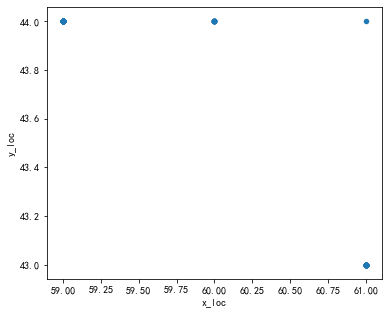

In [22]:
df_all[df_all["ship"]==6966][["x_loc", "y_loc"]].plot.scatter(x='x_loc', y='y_loc', figsize=(6,5))
# plt.xlim(xmin, xmax))
# plt.xlim(0, offset_count)
# plt.ylim(0, offset_count)
plt.show()

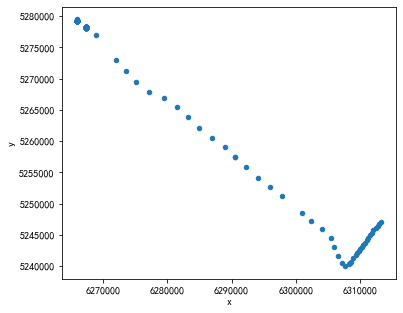

In [23]:
df_all[df_all["ship"]==6966][["x", "y"]].plot.scatter(x='x', y='y', figsize=(6,5))
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
plt.show()

In [24]:
weiwang = df_all[df_all["type"]=="围网"][["x", "y", "x_loc", "y_loc"]]
ciwang = df_all[df_all["type"]=="刺网"][["x", "y", "x_loc", "y_loc"]]
tuowang = df_all[df_all["type"]=="拖网"][["x", "y", "x_loc", "y_loc"]]
testxy = df_all[df_all["type"]=="未知"][["x", "y", "x_loc", "y_loc"]]

type_dict = {
    "围网": weiwang,
    "刺网": ciwang,
    "拖网": tuowang,
    "未知": testxy,
}

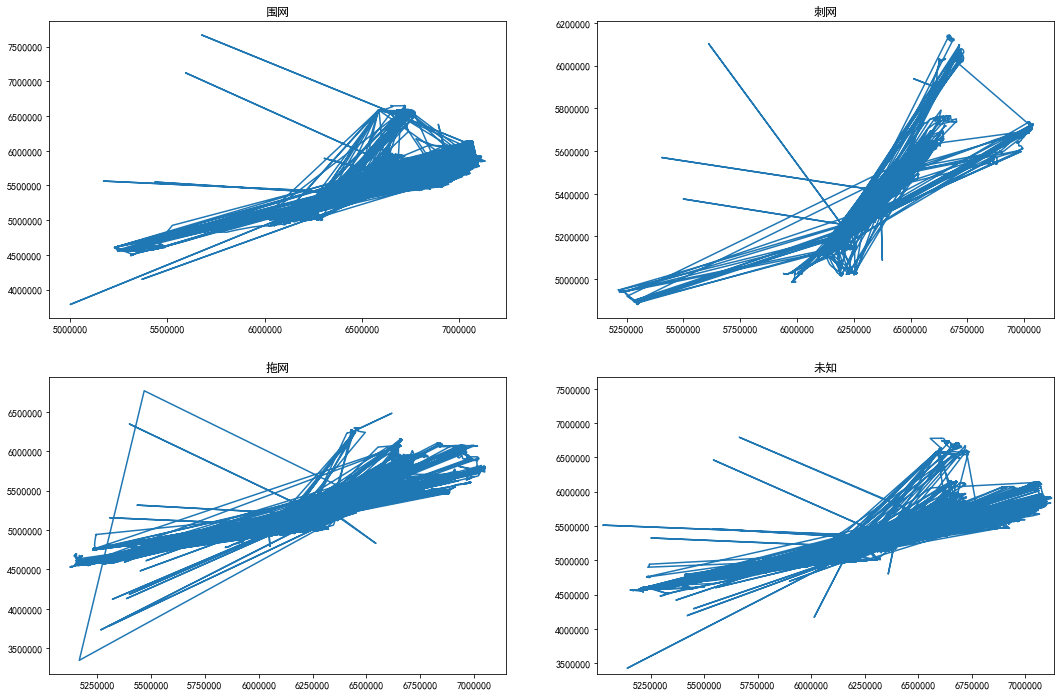

In [25]:
f, ax = plt.subplots(2, 2, figsize=(18,12))

for index, td in enumerate(type_dict.items()):
    title = td[0]
    var = td[1]
    
    i = index//2
    j = index % 2
    ax[i, j].plot(var['x'], var['y'])
    ax[i, j].set_title(title)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

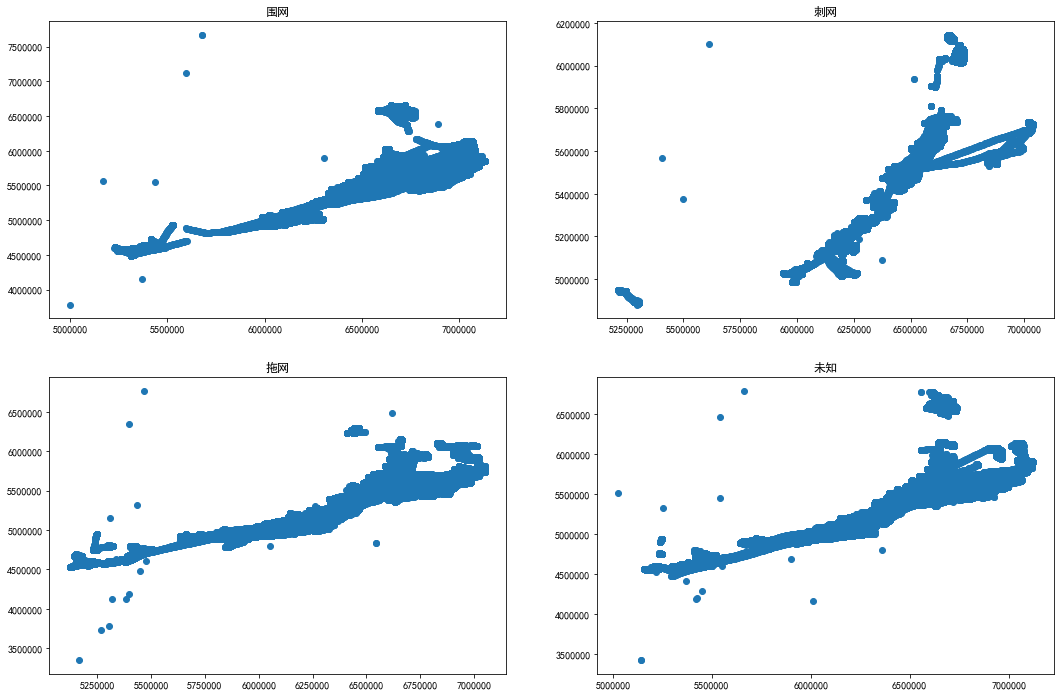

In [26]:
f, ax = plt.subplots(2, 2, figsize=(18,12))

for index, td in enumerate(type_dict.items()):
    title = td[0]
    var = td[1]
    
    i = index//2
    j = index % 2
    ax[i, j].scatter(var['x'], var['y'])
    ax[i, j].set_title(title)

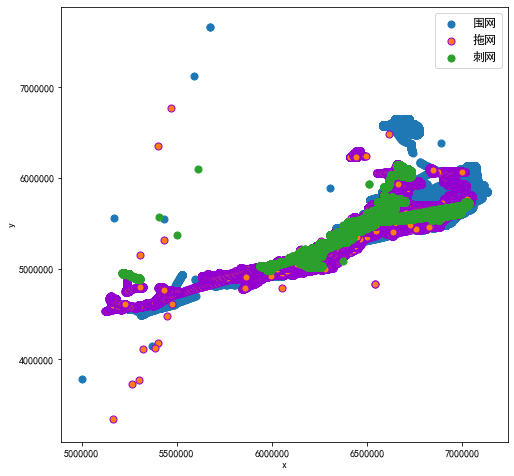

In [27]:
# 颜色库
cm_light_list = ['#A0FFA0', '#FFA0A0', '#A0A0FF', 'khaki', 'paleturquoise', 'plum']
cm_dark_list = ['g', 'r', 'b', 'y', 'skyblue', 'm']

f, ax = plt.subplots(figsize=(8,8))

plt.scatter(weiwang["x"], weiwang["y"], s=50, cmap="khaki")
plt.scatter(tuowang["x"], tuowang["y"], edgecolors='darkviolet', s=50, cmap="paleturquoise")
plt.scatter(ciwang["x"], ciwang["y"], s=50, cmap="plum")

plt.legend(['围网','拖网', '刺网'], loc='upper right', prop={"size": 12})
plt.xlabel("x")
plt.ylabel("y")
plt.show()

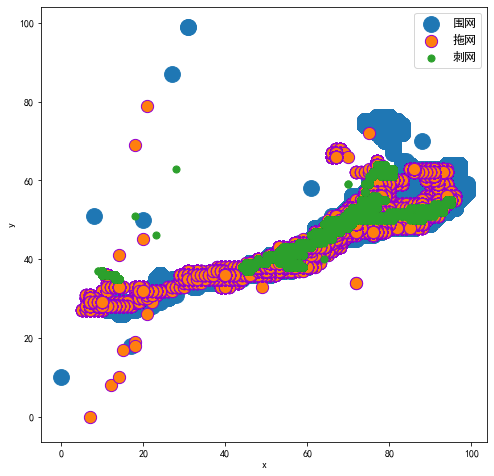

In [28]:
f, ax = plt.subplots(figsize=(8,8))

plt.scatter(weiwang["x_loc"], weiwang["y_loc"], s=250, cmap="khaki")
plt.scatter(tuowang["x_loc"], tuowang["y_loc"], edgecolors='darkviolet', s=150, cmap="paleturquoise")
plt.scatter(ciwang["x_loc"], ciwang["y_loc"], s=50, cmap="plum")
plt.legend(['围网','拖网', '刺网'], loc='upper right', prop={"size": 12})
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [29]:
# df_all = df_all.dropna(axis=0,how='any')
# df_all["speed_time"] = df_all["speed_time"].fillna(method="bfill")

In [30]:
df_all.head(1)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44


In [31]:
df_all["x_y_loc_area"] = df_all['x_loc'].astype(str) + ',' + df_all['y_loc'].astype(str)

In [95]:
df_all.head(10)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy,date,hour,weekday
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44,"59,44",-0.002524,3183.035814,1900-11-06,23,1
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06,-0.063079,-0.152046,-0.255708,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06,-0.757161,1.141901,0.216781,59,44,"59,44",-0.002524,3183.041131,1900-11-06,23,1
5,158,train,6966,601.0,1900-11-06 22:58:16,围网,0.22,6.265902e+06,5.279254e+06,-0.039246,-0.139814,-0.260317,59,44,"59,44",-0.002524,3183.040285,1900-11-06,22,1
6,341,train,6966,600.0,1900-11-06 22:48:16,围网,0.22,6.265902e+06,5.279254e+06,-0.146946,-0.106280,-0.372765,59,44,"59,44",-0.002524,3183.034757,1900-11-06,22,1
7,254,train,6966,530.0,1900-11-06 22:39:26,围网,0.11,6.265902e+06,5.279254e+06,-0.064747,-0.147345,-0.251471,59,44,"59,44",-0.002524,3183.037385,1900-11-06,22,1
8,254,train,6966,74.0,1900-11-06 22:38:12,围网,0.11,6.265902e+06,5.279254e+06,-0.263923,-1.340200,3.420601,59,44,"59,44",-0.002524,3183.037385,1900-11-06,22,1
9,325,train,6966,1167.0,1900-11-06 22:18:45,围网,0.11,6.265902e+06,5.279254e+06,-0.083760,-0.115674,-0.244938,59,44,"59,44",-0.002524,3183.035240,1900-11-06,22,1


In [33]:
df_all.groupby("x_y_loc_area")["x_y_loc_area"].value_counts()

x_y_loc_area  x_y_loc_area
0,10          0,10                1
1,50          1,50                1
10,27         10,27              33
10,28         10,28            5282
10,29         10,29           11933
10,32         10,32             617
10,36         10,36             178
10,37         10,37             208
11,27         11,27               8
11,28         11,28             896
11,32         11,32            4045
11,33         11,33              17
11,34         11,34              15
11,35         11,35              20
11,36         11,36            1918
11,45         11,45               1
12,27         12,27              13
12,28         12,28            1632
12,33         12,33               9
12,36         12,36              40
12,8          12,8                1
13,26         13,26               5
13,27         13,27              38
13,28         13,28            1035
13,29         13,29              12
13,33         13,33              39
13,35         13,35             988
1

In [34]:
df_xyloc = df_all[["x_y_loc_area"]]
df_xyloc.head()

,x_y_loc_area
0,"59,44"
1,"59,44"
2,"59,44"
3,"59,44"
4,"59,44"


In [35]:
# # 转换为one-hot编码
# def OnehotEncoding(df, columns=None):
#     if not columns:
#         col_name_list = df.columns.values

#         obj_list = []
#         for index, d in enumerate(df.dtypes):
#             if d == "object":
#                 obj_list.append(col_name_list[index])

#         columns = obj_list

#     data = df[columns]
#     # 实例化OnehotEncoder
#     enc = OneHotEncoder(categories="auto")
#     # 生成目标特征列One_hot编码
#     data_encoded = enc.fit_transform(data).toarray()
#     # 生成新的列名
#     new_columns = list(enc.get_feature_names())
#     for i, column_name in enumerate(new_columns):
#         df[column_name] = data_encoded[:, i]
#     return df

# df_xyloc = OnehotEncoding(df_xyloc, columns=["x_y_loc_area"])
# df_xyloc.columns.values

df_xyloc_dummies = pd.get_dummies(df_xyloc)
print(df_xyloc_dummies.shape)

(3482016, 907)


In [36]:
df_xyloc_dummies.columns.values

array(['x_y_loc_area_0,10', 'x_y_loc_area_1,50', 'x_y_loc_area_10,27',
       'x_y_loc_area_10,28', 'x_y_loc_area_10,29', 'x_y_loc_area_10,32',
       'x_y_loc_area_10,36', 'x_y_loc_area_10,37', 'x_y_loc_area_11,27',
       'x_y_loc_area_11,28', 'x_y_loc_area_11,32', 'x_y_loc_area_11,33',
       'x_y_loc_area_11,34', 'x_y_loc_area_11,35', 'x_y_loc_area_11,36',
       'x_y_loc_area_11,45', 'x_y_loc_area_12,27', 'x_y_loc_area_12,28',
       'x_y_loc_area_12,33', 'x_y_loc_area_12,36', 'x_y_loc_area_12,8',
       'x_y_loc_area_13,26', 'x_y_loc_area_13,27', 'x_y_loc_area_13,28',
       'x_y_loc_area_13,29', 'x_y_loc_area_13,33', 'x_y_loc_area_13,35',
       'x_y_loc_area_13,36', 'x_y_loc_area_14,10', 'x_y_loc_area_14,26',
       'x_y_loc_area_14,27', 'x_y_loc_area_14,28', 'x_y_loc_area_14,29',
       'x_y_loc_area_14,33', 'x_y_loc_area_14,35', 'x_y_loc_area_14,41',
       'x_y_loc_area_15,17', 'x_y_loc_area_15,26', 'x_y_loc_area_15,27',
       'x_y_loc_area_15,28', 'x_y_loc_area_15,29', 'x_

In [37]:
df_xyloc_dummies.head()

,"x_y_loc_area_0,10","x_y_loc_area_1,50","x_y_loc_area_10,27","x_y_loc_area_10,28","x_y_loc_area_10,29","x_y_loc_area_10,32","x_y_loc_area_10,36","x_y_loc_area_10,37","x_y_loc_area_11,27","x_y_loc_area_11,28","x_y_loc_area_11,32","x_y_loc_area_11,33","x_y_loc_area_11,34","x_y_loc_area_11,35","x_y_loc_area_11,36","x_y_loc_area_11,45","x_y_loc_area_12,27","x_y_loc_area_12,28","x_y_loc_area_12,33","x_y_loc_area_12,36","x_y_loc_area_12,8","x_y_loc_area_13,26","x_y_loc_area_13,27","x_y_loc_area_13,28","x_y_loc_area_13,29","x_y_loc_area_13,33","x_y_loc_area_13,35","x_y_loc_area_13,36","x_y_loc_area_14,10","x_y_loc_area_14,26","x_y_loc_area_14,27","x_y_loc_area_14,28","x_y_loc_area_14,29","x_y_loc_area_14,33","x_y_loc_area_14,35","x_y_loc_area_14,41","x_y_loc_area_15,17","x_y_loc_area_15,26","x_y_loc_area_15,27","x_y_loc_area_15,28","x_y_loc_area_15,29","x_y_loc_area_15,33","x_y_loc_area_16,27","x_y_loc_area_16,28","x_y_loc_area_16,29","x_y_loc_area_17,18","x_y_loc_area_17,24","x_y_loc_area_17,27","x_y_loc_area_17,28","x_y_loc_area_17,29",...,"x_y_loc_area_94,56","x_y_loc_area_94,57","x_y_loc_area_94,58","x_y_loc_area_94,59","x_y_loc_area_94,60","x_y_loc_area_94,61","x_y_loc_area_94,62","x_y_loc_area_94,63","x_y_loc_area_94,64","x_y_loc_area_95,53","x_y_loc_area_95,54","x_y_loc_area_95,55","x_y_loc_area_95,56","x_y_loc_area_95,57","x_y_loc_area_95,58","x_y_loc_area_95,59","x_y_loc_area_95,60","x_y_loc_area_95,61","x_y_loc_area_95,62","x_y_loc_area_95,63","x_y_loc_area_95,64","x_y_loc_area_96,53","x_y_loc_area_96,54","x_y_loc_area_96,55","x_y_loc_area_96,56","x_y_loc_area_96,57","x_y_loc_area_96,58","x_y_loc_area_96,59","x_y_loc_area_96,60","x_y_loc_area_96,61","x_y_loc_area_96,62","x_y_loc_area_96,63","x_y_loc_area_96,64","x_y_loc_area_97,55","x_y_loc_area_97,56","x_y_loc_area_97,57","x_y_loc_area_97,58","x_y_loc_area_97,59","x_y_loc_area_97,60","x_y_loc_area_97,61","x_y_loc_area_97,62","x_y_loc_area_97,63","x_y_loc_area_97,64","x_y_loc_area_98,56","x_y_loc_area_98,57","x_y_loc_area_98,58","x_y_loc_area_98,59","x_y_loc_area_99,57","x_y_loc_area_99,58","x_y_loc_area_99,59"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
print(df_xyloc_dummies.shape)
pca = PCA(n_components=1)
reduced_xy = pca.fit_transform(df_xyloc_dummies)
print(reduced_xy.shape)
df_all["xy_loc_pca"] = reduced_xy

(3482016, 907)
(3482016, 1)


In [39]:
df_all_xy = df_all[["x", "y", "d"]]
print(df_all_xy.shape)
pca = PCA(n_components=1)     #加载PCA算法，设置降维后主成分数目为2
reduced_xy = pca.fit_transform(df_all_xy)#对样本进行降维
print(reduced_xy.shape)
df_all["xy"] = reduced_xy

(3482016, 3)
(3482016, 1)


In [40]:
# df_all_vd = df_all[["v", "d"]]
# print(df_all_vd.shape)
# pca = PCA(n_components=1)     #加载PCA算法，设置降维后主成分数目为2
# reduced_vd = pca.fit_transform(df_all_vd)#对样本进行降维
# print(reduced_vd.shape)
# df_all["vd"] = reduced_vd

In [41]:
df_all.head()

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44,"59,44",-0.002524,3183.035814
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929,59,44,"59,44",-0.002524,3183.045058
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705,59,44,"59,44",-0.002524,3183.045058
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06,-0.063079,-0.152046,-0.255708,59,44,"59,44",-0.002524,3183.045058
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06,-0.757161,1.141901,0.216781,59,44,"59,44",-0.002524,3183.041131


In [42]:
# 处理时间数据
df_all = extract_dt(df_all)

In [43]:
df_all.head()

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy,date,hour,weekday
0,306,train,6966,NaN,1900-11-06 23:58:16,围网,0.11,6.265902e+06,5.279254e+06,-0.111748,-0.075827,-0.215042,59,44,"59,44",-0.002524,3183.035814,1900-11-06,23,1
1,0,train,6966,595.0,1900-11-06 23:48:21,围网,0.00,6.265902e+06,5.279254e+06,-0.191131,0.051766,-0.228929,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
2,0,train,6966,602.0,1900-11-06 23:38:19,围网,0.00,6.265902e+06,5.279254e+06,-0.067810,-0.163246,-0.224705,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
3,0,train,6966,583.0,1900-11-06 23:28:36,围网,0.00,6.265902e+06,5.279254e+06,-0.063079,-0.152046,-0.255708,59,44,"59,44",-0.002524,3183.045058,1900-11-06,23,1
4,130,train,6966,1219.0,1900-11-06 23:08:17,围网,0.32,6.265902e+06,5.279254e+06,-0.757161,1.141901,0.216781,59,44,"59,44",-0.002524,3183.041131,1900-11-06,23,1


In [44]:
# 删除重复行数据
print("df_all", df_all.shape)
df_label = df_all.drop_duplicates('ship')
print("df_label", df_label.shape)

df_all (3482016, 20)
df_label (9000, 20)


In [45]:
# 查看分类占比
df_label['type'].value_counts(1)

拖网    0.484556
未知    0.222222
围网    0.180111
刺网    0.113111
Name: type, dtype: float64

In [46]:
# 标签使用数字代替
type_map = dict(zip(df_label['type'].unique(), np.arange(3)))
type_map_rev = {v:k for k,v in type_map.items()}
df_label['type'] = df_label['type'].map(type_map)
type_map_rev

{0: '围网', 1: '拖网', 2: '刺网'}

In [47]:
# 分类占比
df_label['type'].value_counts(1)

1.0    0.623000
0.0    0.231571
2.0    0.145429
Name: type, dtype: float64

In [48]:
# 构造新列
df_label = extract_feature(df_all, df_label)

In [49]:
# 数据按照ship id排序
df_label = df_label.sort_values("ship")

In [79]:
# 降维后合并
df_label["xy_count_pca_1"] = reduced_xy_count_df[0]
df_label["xy_count_pca_2"] = reduced_xy_count_df[1]
df_label["xy_count_pca_3"] = reduced_xy_count_df[2]
df_label.head(3)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,y_max,y_min,y_mean,y_std,y_skew,y_sum,xy_max,xy_min,xy_mean,xy_std,xy_skew,xy_sum,xy_loc_pca_max,xy_loc_pca_min,xy_loc_pca_mean,xy_loc_pca_std,xy_loc_pca_skew,xy_loc_pca_sum,v_max,v_min,v_mean,v_std,v_skew,v_sum,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,slope,area,mode_hour,hour_max,hour_min,hour_nunique,date_nunique,diff_time,diff_day,diff_second
1038,102,train,0,NaN,1900-11-10 11:58:19,1.0,2.59,6.152038e+06,5.124873e+06,-3.306283,-4.227543,0.913251,53,41,"53,41",-0.002287,192109.042256,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,212500.169706,192109.042256,211899.413905,3103.080484,-5.384109,8.772636e+07,-0.002287,-0.003052,-0.003024,0.000143,4.981695,-1.252093,9.39,0.0,0.265966,1.321248,5.520205,110.11,129,0,4.613527,21.247770,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,0.175380,1.990200e+08,15,23,0,24,4,2 days 23:48:51,2,85731
1202,278,train,1,NaN,1900-11-10 11:40:21,1.0,3.99,6.076254e+06,5.061743e+06,-26.740185,-31.786718,-0.292172,50,39,"50,39",-0.002167,290524.957628,1900-11-10,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,322942.760524,236369.134892,257230.806036,30293.580331,0.883992,9.903386e+07,-0.002115,-0.698551,-0.477872,0.324432,0.790239,-183.980617,10.47,0.0,1.607922,2.412688,1.590284,619.05,336,0,56.153247,91.449382,1.418867,21619,52978.013345,70016.655842,-936597.872550,1.059593e+06,1.321617,3.709343e+09,19,23,0,24,4,2 days 23:39:47,2,85187
1667,145,train,2,NaN,1900-11-17 11:41:58,1.0,0.32,6.183090e+06,5.193685e+06,31.499123,-22.920841,-18.218401,55,42,"55,42",-0.003943,122163.923509,1900-11-17,11,5,6.183191e+06,6.182482e+06,6.183011e+06,207.869601,-2.155218,1.440641e+09,233,5.193696e+06,5.193576e+06,5.193682e+06,21.740609,-4.563165,1.210128e+09,122596.045033,122091.895199,122223.132157,147.464347,2.114164,2.847799e+07,-0.003943,-0.003943,-0.003943,0.000000,0.000000,-0.918627,50.46,0.0,0.595150,3.415824,13.631590,138.67,360,0,123.356223,123.097127,0.657506,28742,708.835147,120.565000,-988786.086021,9.896155e+05,0.170089,8.546071e+04,17,23,0,24,4,2 days 23:34:57,2,84897


In [80]:
df_label.head(10)

,d,record,ship,speed_time,time,type,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,x_loc,y_loc,x_y_loc_area,xy_loc_pca,xy,date,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,y_max,y_min,y_mean,y_std,y_skew,y_sum,xy_max,xy_min,xy_mean,xy_std,xy_skew,xy_sum,xy_loc_pca_max,xy_loc_pca_min,xy_loc_pca_mean,xy_loc_pca_std,xy_loc_pca_skew,xy_loc_pca_sum,v_max,v_min,v_mean,v_std,v_skew,v_sum,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,slope,area,mode_hour,hour_max,hour_min,hour_nunique,date_nunique,diff_time,diff_day,diff_second
1038,102,train,0,NaN,1900-11-10 11:58:19,1.0,2.59,6.152038e+06,5.124873e+06,-3.306283,-4.227543,0.913251,53,41,"53,41",-0.002287,1.921090e+05,1900-11-10,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,2.125002e+05,1.921090e+05,2.118994e+05,3103.080484,-5.384109,8.772636e+07,-0.002287,-0.003052,-0.003024,0.000143,4.981695,-1.252093,9.39,0.00,0.265966,1.321248,5.520205,110.11,129,0,4.613527,21.247770,4.483093,1910,33686.667453,5907.975523,-9.875704e+05,1.027165e+06,0.175380,1.990200e+08,15,23,0,24,4,2 days 23:48:51,2,85731
1202,278,train,1,NaN,1900-11-10 11:40:21,1.0,3.99,6.076254e+06,5.061743e+06,-26.740185,-31.786718,-0.292172,50,39,"50,39",-0.002167,2.905250e+05,1900-11-10,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,3.229428e+05,2.363691e+05,2.572308e+05,30293.580331,0.883992,9.903386e+07,-0.002115,-0.698551,-0.477872,0.324432,0.790239,-183.980617,10.47,0.00,1.607922,2.412688,1.590284,619.05,336,0,56.153247,91.449382,1.418867,21619,52978.013345,70016.655842,-9.365979e+05,1.059593e+06,1.321617,3.709343e+09,19,23,0,24,4,2 days 23:39:47,2,85187
1667,145,train,2,NaN,1900-11-17 11:41:58,1.0,0.32,6.183090e+06,5.193685e+06,31.499123,-22.920841,-18.218401,55,42,"55,42",-0.003943,1.221639e+05,1900-11-17,11,5,6.183191e+06,6.182482e+06,6.183011e+06,207.869601,-2.155218,1.440641e+09,233,5.193696e+06,5.193576e+06,5.193682e+06,21.740609,-4.563165,1.210128e+09,1.225960e+05,1.220919e+05,1.222231e+05,147.464347,2.114164,2.847799e+07,-0.003943,-0.003943,-0.003943,0.000000,0.000000,-0.918627,50.46,0.00,0.595150,3.415824,13.631590,138.67,360,0,123.356223,123.097127,0.657506,28742,708.835147,120.565000,-9.887861e+05,9.896155e+05,0.170089,8.546071e+04,17,23,0,24,4,2 days 23:34:57,2,84897
1481,0,train,3,NaN,1900-11-10 11:50:10,1.0,0.32,5.229849e+06,4.608510e+06,-4.664182,11.188356,19.647408,10,29,"10,29",-0.002113,1.215981e+06,1900-11-10,11,5,5.287805e+06,5.228590e+06,5.239159e+06,17503.714347,1.608637,1.755118e+09,335,4.608628e+06,4.577467e+06,4.601532e+06,11590.605179,-1.194210,1.541513e+09,1.221227e+06,1.194662e+06,1.214053e+06,5489.168217,-2.128148,4.067078e+08,-0.002040,-0.002113,-0.002095,0.000031,1.098415,-0.701709,10.09,0.00,1.471343,2.528593,2.135446,492.90,352,0,121.134328,121.758165,0.469794,40580,59214.738740,31160.661097,-6.199621e+05,7.103375e+05,0.526232,1.845170e+09,22,23,0,24,4,2 days 23:34:59,2,84899
734,119,train,4,NaN,1900-11-17 11:57:24,0.0,0.22,7.061772e+06,6.125021e+06,-9.251175,-39.396416,4.012257,96,64,"96,64",-0.002102,-1.156432e+06,1900-11-17,11,5,7.070797e+06,7.049394e+06,7.062005e+06,5979.578887,-0.596732,2.831864e+09,401,6.136033e+06,6.094996e+06,6.116389e+06,12055.148984,-0.331618,2.452672e+09,-1.126953e+06,-1.166557e+06,-1.150648e+06,11618.666709,0.771256,-4.614098e+08,-0.002037,-0.002102,-0.002088,0.000023,1.595479,-0.837106,10.09,0.00,1.412219,2.496836,1.910336,566.30,359,0,139.067332,121.130025,0.372601,55766,21402.484584,41036.883038,-9.133614e+05,9.758007e+05,1.917389,8.782913e+08,23,23,0,24,4,2 days 23:57:12,2,86232
606,212,train,5,NaN,1900-11-06 23:52:56,1.0,2.81,6.388833e+06,5.340338e+06,14.319056,-3.761552,29.898129,65,46,"65,46",-0.002110,-1.279585e+05,1900-11-06,23,1,6.503900e+06,6.388833e+06,6.488945e+06,22271.7607

In [81]:
# 拆出暂不需要的特征
delete_list = ['speed_time', "record", 'ship','type','time','diff_time','date', 'hour_nunique',
               'x_y_loc_area', 'x_loc', 'y_loc']
features = [x for x in df_label.columns if x not in delete_list]
target = 'type'

# features = []

In [82]:
# 查看训练用到的列
print(len(features), '\n,'.join(features))

60 d
,v
,x
,y
,xy_count_pca_1
,xy_count_pca_2
,xy_count_pca_3
,xy_loc_pca
,xy
,hour
,weekday
,x_max
,x_min
,x_mean
,x_std
,x_skew
,x_sum
,x_count
,y_max
,y_min
,y_mean
,y_std
,y_skew
,y_sum
,xy_max
,xy_min
,xy_mean
,xy_std
,xy_skew
,xy_sum
,xy_loc_pca_max
,xy_loc_pca_min
,xy_loc_pca_mean
,xy_loc_pca_std
,xy_loc_pca_skew
,xy_loc_pca_sum
,v_max
,v_min
,v_mean
,v_std
,v_skew
,v_sum
,d_max
,d_min
,d_mean
,d_std
,d_skew
,d_sum
,x_max_x_min
,y_max_y_min
,y_max_x_min
,x_max_y_min
,slope
,area
,mode_hour
,hour_max
,hour_min
,date_nunique
,diff_day
,diff_second


In [83]:
# lgbm的参数
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
}

In [84]:
train_label = df_label[df_label["record"] == "train"]
test_label = df_label[df_label["record"] == "test"]

In [85]:
train_label = train_label.drop(["record"], axis=1)
test_label = test_label.drop(["record", "type"], axis=1)

In [86]:
train_label[features].head(3)

,d,v,x,y,xy_count_pca_1,xy_count_pca_2,xy_count_pca_3,xy_loc_pca,xy,hour,weekday,x_max,x_min,x_mean,x_std,x_skew,x_sum,x_count,y_max,y_min,y_mean,y_std,y_skew,y_sum,xy_max,xy_min,xy_mean,xy_std,xy_skew,xy_sum,xy_loc_pca_max,xy_loc_pca_min,xy_loc_pca_mean,xy_loc_pca_std,xy_loc_pca_skew,xy_loc_pca_sum,v_max,v_min,v_mean,v_std,v_skew,v_sum,d_max,d_min,d_mean,d_std,d_skew,d_sum,x_max_x_min,y_max_y_min,y_max_x_min,x_max_y_min,slope,area,mode_hour,hour_max,hour_min,date_nunique,diff_day,diff_second
1038,102,2.59,6.152038e+06,5.124873e+06,-3.306283,-4.227543,0.913251,-0.002287,192109.042256,11,5,6.152038e+06,6.118352e+06,6.119351e+06,5037.320747,5.255558,2.533411e+09,414,5.130781e+06,5.124873e+06,5.130494e+06,850.264541,-4.762308,2.124025e+09,212500.169706,192109.042256,211899.413905,3103.080484,-5.384109,8.772636e+07,-0.002287,-0.003052,-0.003024,0.000143,4.981695,-1.252093,9.39,0.0,0.265966,1.321248,5.520205,110.11,129,0,4.613527,21.247770,4.483093,1910,33686.667453,5907.975523,-987570.399385,1.027165e+06,0.175380,1.990200e+08,15,23,0,4,2,85731
1202,278,3.99,6.076254e+06,5.061743e+06,-26.740185,-31.786718,-0.292172,-0.002167,290524.957628,11,5,6.102450e+06,6.049472e+06,6.091460e+06,16543.394419,-1.058454,2.345212e+09,385,5.112874e+06,5.042857e+06,5.094050e+06,26764.042729,-0.802446,1.961209e+09,322942.760524,236369.134892,257230.806036,30293.580331,0.883992,9.903386e+07,-0.002115,-0.698551,-0.477872,0.324432,0.790239,-183.980617,10.47,0.0,1.607922,2.412688,1.590284,619.05,336,0,56.153247,91.449382,1.418867,21619,52978.013345,70016.655842,-936597.872550,1.059593e+06,1.321617,3.709343e+09,19,23,0,4,2,85187
1667,145,0.32,6.183090e+06,5.193685e+06,31.499123,-22.920841,-18.218401,-0.003943,122163.923509,11,5,6.183191e+06,6.182482e+06,6.183011e+06,207.869601,-2.155218,1.440641e+09,233,5.193696e+06,5.193576e+06,5.193682e+06,21.740609,-4.563165,1.210128e+09,122596.045033,122091.895199,122223.132157,147.464347,2.114164,2.847799e+07,-0.003943,-0.003943,-0.003943,0.000000,0.000000,-0.918627,50.46,0.0,0.595150,3.415824,13.631590,138.67,360,0,123.356223,123.097127,0.657506,28742,708.835147,120.565000,-988786.086021,9.896155e+05,0.170089,8.546071e+04,17,23,0,4,2,84897


In [91]:
# lgbm的参数
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100,
    'learning_rate': 0.01,
}

# 交叉验证 五折
fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 特征和标签
X = train_label[features].copy()
y = train_label[target]

# 模型列表
models = []
# 预测值
pred = np.zeros((len(test_label),3))  # onehot形式 (2000, 3)
oof = np.zeros((len(X), 3))  # onehot形式 (7000, 3)

# 循环交叉验证
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):

    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])  # 筛选训练数据
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])        # 筛选验证数据

    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)  # 训练模型
    models.append(model)  # 模型列表
    
    # 预测标签，每个结果是 (len ,3)
    val_pred = model.predict(X.iloc[val_idx])  
    oof[val_idx] = val_pred
    
    # 原始标签
    val_y = y.iloc[val_idx]
    
    # 输出最大值
    val_pred = np.argmax(val_pred, axis=1)
    
    # 计算f1值
    print(index, 'val f1(指定次数的随机验证集F1值: )', metrics.f1_score(val_y, val_pred, average='macro'))
    
    # 预测待提交测试集结果
    test_pred = model.predict(test_label[features])
    pred += test_pred/5

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.474735	valid_1's multi_logloss: 0.51552
[200]	training's multi_logloss: 0.324752	valid_1's multi_logloss: 0.386281
[300]	training's multi_logloss: 0.247992	valid_1's multi_logloss: 0.33337
[400]	training's multi_logloss: 0.200379	valid_1's multi_logloss: 0.302513
[500]	training's multi_logloss: 0.166219	valid_1's multi_logloss: 0.28538
[600]	training's multi_logloss: 0.140946	valid_1's multi_logloss: 0.277472
[700]	training's multi_logloss: 0.120306	valid_1's multi_logloss: 0.270139
[800]	training's multi_logloss: 0.103637	valid_1's multi_logloss: 0.265391
[900]	training's multi_logloss: 0.0893467	valid_1's multi_logloss: 0.261993
[1000]	training's multi_logloss: 0.0770415	valid_1's multi_logloss: 0.257562
[1100]	training's multi_logloss: 0.0670371	valid_1's multi_logloss: 0.25569
[1200]	training's multi_logloss: 0.0582224	valid_1's multi_logloss: 0.253931
[1300]	training's multi_logloss: 0

[1400]	training's multi_logloss: 0.0430385	valid_1's multi_logloss: 0.242433
[1500]	training's multi_logloss: 0.0374174	valid_1's multi_logloss: 0.242103
Early stopping, best iteration is:
[1485]	training's multi_logloss: 0.0381971	valid_1's multi_logloss: 0.241893
5 val f1(指定次数的随机验证集F1值: ) 0.8673508321096248
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.475813	valid_1's multi_logloss: 0.51979
[200]	training's multi_logloss: 0.327149	valid_1's multi_logloss: 0.40329
[300]	training's multi_logloss: 0.250239	valid_1's multi_logloss: 0.352562
[400]	training's multi_logloss: 0.200907	valid_1's multi_logloss: 0.321191
[500]	training's multi_logloss: 0.167061	valid_1's multi_logloss: 0.303521
[600]	training's multi_logloss: 0.140969	valid_1's multi_logloss: 0.292836
[700]	training's multi_logloss: 0.120354	valid_1's multi_logloss: 0.286608
[800]	training's multi_logloss: 0.103435	valid_1's multi_logloss: 0.28147
[900]	training's multi_loglos

In [92]:
# 综合五次的交叉验证的结果评估值
oof = np.argmax(oof, axis=1)
print('【准确率】oof f1: ', metrics.f1_score(oof, y, average='macro'))

# origin 0.8666565020816382
# speed time 0.8556040441133175
# speed time + xy 0.869776300826063
# xy 0.8695008449788421
# speed time + xyvd 0.8666262659963254
# speed time + xyd 0.8712710026618916
# speed time + xyv 0.8677183665397498
# speed time + xy + vd 0.8657659692232876
# speed time + xyd + vd 0.8683521658107259
# xy loc 0.8755378306270695

【准确率】oof f1:  0.8793114715596317


In [1]:
test_pred

NameError: name 'test_pred' is not defined

In [73]:
pred = np.argmax(pred, axis=1)
sub = test_label[['ship']]
sub['pred'] = pred

print(sub['pred'].value_counts(1))
sub['pred'] = sub['pred'].map(type_map_rev)
sub.to_csv('result.csv', index=None, header=None)

1    0.6405
0    0.2290
2    0.1305
Name: pred, dtype: float64


In [74]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)

In [75]:
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)

In [76]:
df

,name,score
53,y_max_x_min,509.0
21,v_std,414.0
28,x_max_y_min,406.4
20,v_skew,359.4
30,x_min,321.0
48,xy_skew,315.6
40,xy_loc_pca_mean,308.0
52,y_max,303.4
24,x,302.4
51,y,299.2


In [93]:
df.shape

(60, 2)